# 學習日期: 2022/5/9
## 目標: 透過LSTM模型，預測COVID-19確診人數
- **參考資料1:** https://jishuin.proginn.com/p/763bfbd700c2
- **參考資料2:** https://github.com/CSSEGISandData/COVID-19

## 1. 數據分析

In [1]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
#import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

In [2]:
df = pd.read_csv('2020-2021_time_series_covid19_confirmed_global.csv')  # 將csv載入到DataFrame中; usecols=指定載入的行名
#df = pd.read_csv('2020-2021_time_series_covid19_confirmed_global.csv', usecols = ["Lat","Long"])
print(df.head())

  Province/State Country/Region       Lat       Long  2020-1-22  2020-1-23  \
0            NaN    Afghanistan  33.93911  67.709953          0          0   
1            NaN        Albania  41.15330  20.168300          0          0   
2            NaN        Algeria  28.03390   1.659600          0          0   
3            NaN        Andorra  42.50630   1.521800          0          0   
4            NaN         Angola -11.20270  17.873900          0          0   

   2020-1-24  2020-1-25  2020-1-26  2020-1-27  ...  2021-12-22  2021-12-23  \
0          0          0          0          0  ...      157841      157878   
1          0          0          0          0  ...      206616      206935   
2          0          0          0          0  ...      215430      215723   
3          0          0          0          0  ...       21372       21571   
4          0          0          0          0  ...       67199       68362   

   2021-12-24  2021-12-25  2021-12-26  2021-12-27  2021-12-28 

In [3]:
df = df.iloc[:,4:]  # 切掉不要的行(column_index)
print(df.head())  # 內容值=0,157841... ;  column_index=2020-1-22... ;  row_index=0,1,2,3

   2020-1-22  2020-1-23  2020-1-24  2020-1-25  2020-1-26  2020-1-27  \
0          0          0          0          0          0          0   
1          0          0          0          0          0          0   
2          0          0          0          0          0          0   
3          0          0          0          0          0          0   
4          0          0          0          0          0          0   

   2020-1-28  2020-1-29  2020-1-30  2020-1-31  ...  2021-12-22  2021-12-23  \
0          0          0          0          0  ...      157841      157878   
1          0          0          0          0  ...      206616      206935   
2          0          0          0          0  ...      215430      215723   
3          0          0          0          0  ...       21372       21571   
4          0          0          0          0  ...       67199       68362   

   2021-12-24  2021-12-25  2021-12-26  2021-12-27  2021-12-28  2021-12-29  \
0      157887      157895  

In [4]:
isnull = df.isnull().sum().sum()  #檢查缺失值
print(isnull)

0


In [5]:
daily_cases = df.sum(axis=0)  # 0:每一列的內容值互相相加 (列1+...+列n =列sum_下面);  1:每一行的內容值相加 (=行sum_右邊)
print("數據=\n",daily_cases.head())
print("日期=\n",daily_cases.index)

daily_cases.index = pd.to_datetime(daily_cases.index)  # column index(時間)的智慧轉換

print("日期(智慧轉換)=",daily_cases.index)

數據=
 2020-1-22     557
2020-1-23     657
2020-1-24     944
2020-1-25    1437
2020-1-26    2120
dtype: int64
日期=
 Index(['2020-1-22', '2020-1-23', '2020-1-24', '2020-1-25', '2020-1-26',
       '2020-1-27', '2020-1-28', '2020-1-29', '2020-1-30', '2020-1-31',
       ...
       '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25', '2021-12-26',
       '2021-12-27', '2021-12-28', '2021-12-29', '2021-12-30', '2021-12-31'],
      dtype='object', length=710)
日期(智慧轉換)= DatetimeIndex(['2020-01-22', '2020-01-23', '2020-01-24', '2020-01-25',
               '2020-01-26', '2020-01-27', '2020-01-28', '2020-01-29',
               '2020-01-30', '2020-01-31',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', length=710, freq=None)


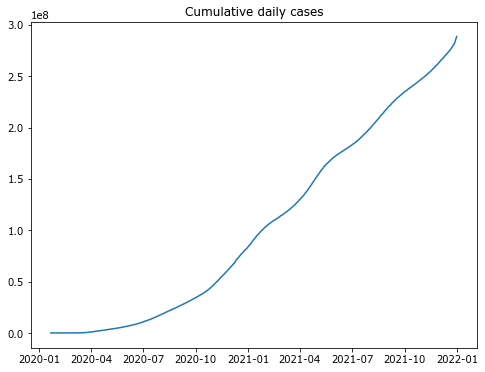

In [6]:
x = daily_cases.index  # 取column index(2020-01)
y = daily_cases.values  # 取DataFrame的內容值

plt.figure(figsize=(8,6))
plt.title('Cumulative daily cases')
plt.plot(x, y)
plt.show()

In [7]:
print("原本累加:")
print(daily_cases.head())

print("\n轉成每日數量:")
temp = daily_cases.diff()  #預設是計算每一列做相減
print(temp.head())

print("\n填充NaN值後:")
daily_cases = temp.fillna(value=daily_cases[0])
print(daily_cases.head())

print("\n轉int後:")
daily_cases = daily_cases.astype(np.int64)  # 轉成int64
print(daily_cases.head())

print("\nShape: ",daily_cases.shape)

原本累加:
2020-01-22     557
2020-01-23     657
2020-01-24     944
2020-01-25    1437
2020-01-26    2120
dtype: int64

轉成每日數量:
2020-01-22      NaN
2020-01-23    100.0
2020-01-24    287.0
2020-01-25    493.0
2020-01-26    683.0
dtype: float64

填充NaN值後:
2020-01-22    557.0
2020-01-23    100.0
2020-01-24    287.0
2020-01-25    493.0
2020-01-26    683.0
dtype: float64

轉int後:
2020-01-22    557
2020-01-23    100
2020-01-24    287
2020-01-25    493
2020-01-26    683
dtype: int64

Shape:  (710,)


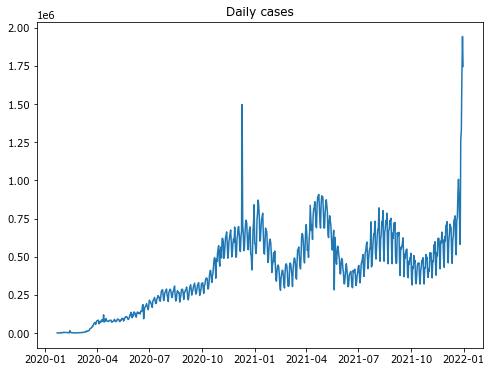

In [8]:
x = daily_cases.index  # 取column index(2020-01)
y = daily_cases.values  # 取DataFrame的內容值

plt.figure(figsize=(8,6))
plt.title('Daily cases')
plt.plot(x, y)
plt.show()

## 2. 數據預處理

In [9]:
print("有", daily_cases.size,"天的數據")
test_data_size = 243
train_data = daily_cases[:-test_data_size]  # 取前面
test_data = daily_cases[train_data.size:]  # 取後面
print("\n訓練集",train_data.size,"天\n預測集",test_data.size,"天")

print("\ntrain_data=\n",train_data)
print("\ntest_data=\n",test_data)

有 710 天的數據

訓練集 467 天
預測集 243 天

train_data=
 2020-01-22       557
2020-01-23       100
2020-01-24       287
2020-01-25       493
2020-01-26       683
               ...  
2021-04-28    898624
2021-04-29    895026
2021-04-30    891776
2021-05-01    794957
2021-05-02    687177
Length: 467, dtype: int64

test_data=
 2021-05-03     689172
2021-05-04     785654
2021-05-05     842368
2021-05-06     872575
2021-05-07     834989
               ...   
2021-12-27    1268219
2021-12-28    1326584
2021-12-29    1696421
2021-12-30    1942505
2021-12-31    1745974
Length: 243, dtype: int64


In [10]:
# 提高模型的"訓練速度"、"性能" ---> 按比例縮放數據(0~1)
# 使用scikit-learn的MinMaxScaler(最小最大值標準化)
# Reference: https://cloud.tencent.com/developer/article/1770568

# 注意: 是用train data進行擬合fit(模型)，然後對 train & test 都用此模型進行 trainsform (因fit兩次會造成在不同標準下做trainsform)
## train: fit + transform
## test: transform

# DataFrame(467行) -> values內容值(467列,1行)
train_data = np.expand_dims(train_data, axis=1)  # (467列，1列存放1個數值)
test_data = np.expand_dims(test_data, axis=1)    # axis=1: (467) -> (467,1)

print("轉換前:")
print(train_data[:5])

# 1. fit: (做完就包含數據分布情況，但未歸一化)
scalar_type = MinMaxScaler()  # 選擇計算類型
scalar = scalar_type.fit(train_data)  # 自動算出"最大值" "最小值"
#print(scalar.data_max_)  # 測試: 最大值


# 2. transform: (train)
train_data = scalar.transform(train_data)  # 歸一化 (意思是，將數據壓縮到0-1之間，對應MinMax規範方法)
    # 歸一化可以消除量綱對最終結果的影響，使不同變數具有可比性。
    # 例子: 比如兩個人體重差10KG，身高差0.02M，在衡量兩個人的差別時體重的差距會把身高的差距完全掩蓋，歸一化之後就不會有這樣的問題。
    
print("\n轉換後:")
print(train_data[:5])

# 2. transform: (test)
test_data = scalar.transform(test_data)

轉換前:
[[557]
 [100]
 [287]
 [493]
 [683]]

轉換後:
[[0.00030536]
 [0.        ]
 [0.00012495]
 [0.00026259]
 [0.00038955]]


In [11]:
# 七天一個循環 (x:前7天  y_label:第8天)

print("train data=",len(train_data),"\n")
data = train_data

def create_sequence(data, seq_length):
    x_list = []
    y_list = []
    for i in range(len(data)-seq_length-1):  # 因最後要多一筆label data，所以-1
        x = data[i:i+seq_length]  # 0~6
        y = data[i+seq_length]  # 7
        x_list.append(x)
        y_list.append(y)
        
    return np.array(x_list), np.array(y_list)

seq_length = 7  # time_step

train_x, train_y = create_sequence(train_data, seq_length)
test_x, test_y = create_sequence(test_data, seq_length)

train_x = torch.from_numpy(train_x)
train_y = torch.from_numpy(train_y).float()
test_x = torch.from_numpy(test_x).float()
test_y = torch.from_numpy(test_y).float()

print("train x=",train_x.shape)
print("train y=",train_y.shape,"\n")
print(train_x[0],"\n")  # !!!原本數據類型: float64 -> 餵入model數據 要轉成 float32 才能run

train_x = train_x.float()  # float64 -> float32
print(train_x[0])

train data= 467 

train x= torch.Size([459, 7, 1])
train y= torch.Size([459, 1]) 

tensor([[0.0003],
        [0.0000],
        [0.0001],
        [0.0003],
        [0.0004],
        [0.0005],
        [0.0017]], dtype=torch.float64) 

tensor([[0.0003],
        [0.0000],
        [0.0001],
        [0.0003],
        [0.0004],
        [0.0005],
        [0.0017]])


## 3. 建立模型-LSTM

In [12]:

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, seq_length):  # 這裡加入要傳入的參數，使用時記得要加self.X = X
        super(LSTM, self).__init__()
        
        # 導入參數
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.seq_length = seq_length
        
        # model設計
        self.rnn = nn.LSTM(
            input_size = input_size,  # input shape
            hidden_size = hidden_size,  # output shape
            num_layers = num_layers,
            dropout = dropout
            #batch_first = True  # 只是做 原(459,7,1) -> (7,459,1)，這次沒有設batch_size，固batch_size=459 (全部data)
                                 # (batch_size, time_step, input_size) batch已經在最前面，不需再batch_first
        )
        self.out = nn.Linear(hidden_size, 1)  # (in_features, out_features)->(512, 1)
        
    def reset_hidden_state(self):  # 清空inputs的 h_0, c_0 (state)->讓每個epoch開始訓練 都是空的state
        self.h_0 = torch.zeros(self.num_layers, self.seq_length, self.hidden_size)  # 透過self，抓取外界傳入的參數(初始化需先導入)
        self.c_0 = torch.zeros(self.num_layers, self.seq_length, self.hidden_size)
        
    def forward(self, x):
        """
        x: (batch_size, time_step(seq_length), input_size)
        h_n = 最後一個time_step的 "hidden state" (輸出)   h_n = lstm_out[:,-1,:]
        c_n = 最後一個time_step的 "cell state" (cell當前狀態)
        """
        
        #---x: (459, 7, 1)    
        lstm_out, (self.h_n, self.c_n) = self.rnn(x, (self.h_0, self.c_0))  # 1 -> 512 
        #---lstm_out: (459, 7, 512)
        
        # 查看hidden_state (tuple → tensor)
        #hidden_state = torch.stack(list((self.h_0,self.c_0)), dim=0)  # h_n, c_n = hidden_state = (2, num_layers, 7, 512)
        #print(hidden_state.shape)  # hidden_state: ( (h,c), num_layers, time_step(seq_length), hidden_size)
        
        #---lstm_out: (459, 7, 512)
        last_time_step = lstm_out.view(7, len(x), 512)  # 改變數據shape (取出 7的最後一個 時間步(time_step) 的輸出)
        #---last_time_step: (7, 459, 512)
        last_time_step = last_time_step[-1]  # 取0~6的最後一列
        #---last_time_step: (459, 512)
        output = self.out(last_time_step)  # (459, 512) -> (459, 1)
        #---output: (459, 1)  # 459列 預測的結果
        
        return output  # y_predict

[lstm_out、h_n 和 c_n 之間的關係](https://blog.csdn.net/sdnuwjw/article/details/111221937)
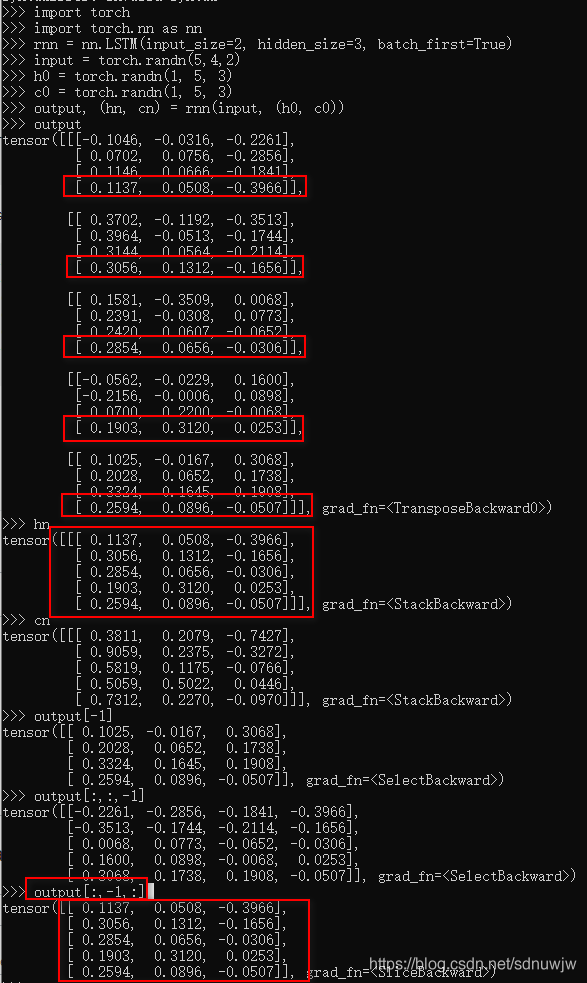

## 訓練模型

In [13]:
def train_model(model, epoch, train_data, train_label, test_data, test_label):
    # 設定loss模型 + 優化器
    loss_fn = torch.nn.MSELoss(reduction='sum')  # 默認'mean'
    optim = torch.optim.Adam(params=model.parameters(), lr=1e-3)
    
    # 保存loss歷史數據，plt看圖用
    train_loss_list = np.zeros(epoch)
    test_loss_list = np.zeros(epoch)
    
    for i in range(epoch):
        model.train()  # 開啟訓練模式
        model.reset_hidden_state()  # 無狀態LSTM
        
        #---train_data: (459, 7, 1)
        y_pred = model(train_data)
        #---y_pred: (459, 1)
        
        # 比較data差異
        #print(train_label[5])
        #print(y_pred[5])
        
        # 計算loss
        loss = loss_fn(y_pred, train_label)  # (y_predict, y_label)
        
        # 加入測試集驗證
        if test_data is not None:
            with torch.no_grad():  # 被該語句包裹起來的程式碼，就不會被追蹤gradient
                y_pred_test = model(test_data)
                loss_test = loss_fn(y_pred_test, test_label)
            test_loss_list[i] = loss_test.item()  # 保存loss_test history
            if (i%10 == 0) or (i == epoch-1):  # 最後一個epoch也印出
                print(f'Epoch {i}  train loss: {loss.item():.4f}  test loss: {loss_test.item():.4f}')  # :.4f 取小數後四位
        elif i%10 == 0:
            print(f'Epoch {i}  train loss: {loss.item()}')  # .item(): tensor->內容值(values)
        
        train_loss_list[i] = loss.item()  # 保存loss history
        
        # 固定不變
        optim.zero_grad()
        loss.backward()
        optim.step()

    return model.eval(), train_loss_list, test_loss_list  # model.eval() 因後面是測試模式

In [14]:
# 設定參數
epoch = 20
input_size = 1  # 若為圖片，size= W x H，這裡是確診人數，size= 1
hidden_size = 512  # 隱藏層神經元數
num_layers = 2  # LSTM層數
dropout = 0.5
seq_length = 7  # 就是time_step; 若要調值，上面 "2.數據預處理-seq_length" 也要改


model = LSTM(input_size, hidden_size, num_layers, dropout, seq_length)
print("x =",train_x.shape, "  (batch_size, time_step, input_size)\n")

# 開始訓練
model, train_loss_list, test_loss_list = train_model(model, epoch, train_x, train_y, test_x, test_y) # model = .eval()測試模式

x = torch.Size([459, 7, 1])   (batch_size, time_step, input_size)

Epoch 0  train loss: 37.1533  test loss: 36.4869
Epoch 10  train loss: 11.4514  test loss: 7.7270
Epoch 19  train loss: 6.8971  test loss: 4.5753


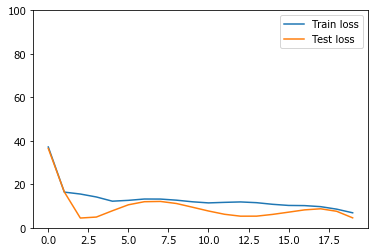

In [15]:
plt.plot(train_loss_list, label='Train loss')
plt.plot(test_loss_list, label='Test loss')
plt.ylim((0, 100))
plt.legend()